# Detección de Objetos: You Only Look Once

In [1]:
# Pesos descargados desde https://pjreddie.com/darknet/yolo/ #PAGINA DE YOLO
!wget www.ivan-sipiran.com/downloads/yolo.zip
!unzip yolo.zip

--2020-11-07 17:18:25--  http://www.ivan-sipiran.com/downloads/yolo.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233686170 (223M) [application/zip]
Saving to: ‘yolo.zip’

yolo.zip            100%[===================>] 222.86M  43.1MB/s    in 5.6s    

2020-11-07 17:18:30 (39.7 MB/s) - ‘yolo.zip’ saved [233686170/233686170]

Archive:  yolo.zip
   creating: config/
  inflating: config/coco.data        
  inflating: config/coco.names       
  inflating: config/download_weights.sh  
  inflating: config/yolov3-tiny.cfg  
  inflating: config/yolov3.cfg       
  inflating: config/yolov3.weights   
   creating: images/
  inflating: images/blueangels-det.jpg  
  inflating: images/blueangels.jpg   
  inflating: images/Intersection-Counts.jpg  
  inflating: images/olympic-trials.jpg  
   creating: utils/
  inflating: utils/dat

In [2]:
!wget dealain.com/descargas/yolo_files.zip
!unzip yolo_files.zip

--2020-11-07 17:18:51--  http://dealain.com/descargas/yolo_files.zip
Resolving dealain.com (dealain.com)... 192.185.91.239
Connecting to dealain.com (dealain.com)|192.185.91.239|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11311733 (11M) [application/zip]
Saving to: ‘yolo_files.zip’

yolo_files.zip      100%[===================>]  10.79M  14.8MB/s    in 0.7s    

2020-11-07 17:18:52 (14.8 MB/s) - ‘yolo_files.zip’ saved [11311733/11311733]

Archive:  yolo_files.zip
  inflating: people.jpg              
  inflating: test2_cam1_100.MP4      
   creating: __MACOSX/
  inflating: __MACOSX/._test2_cam1_100.MP4  
  inflating: traffic.jpg             


In [3]:
#EN MODELS.PY SE ENCUENTRA LA ARQUITECTURA DE LA RED
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

## 1. Cargando el modelo y los pesos

In [6]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
nms_thres=0.4

model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path) # 80 clases
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [8]:
len(classes)

80

In [9]:
classes #tipos de objetos que puede detectar

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

## 2. Detectando objetos en imagenes

In [11]:
def detect_image(img):
  ''' Detecta todos los objetos previous en una imagen '''

  # escalar y rellenar imagen
  ratio = min(img_size/img.size[0], img_size/img.size[1])
  imw = round(img.size[0] * ratio)
  imh = round(img.size[1] * ratio)
  
  #aplicamos transformaciones a la imagen
  #esencialmente es un padding para ampliar anchura
  img_transforms = transforms.Compose([transforms.Resize((imh, imw)),
        transforms.Pad((max(int((imh-imw)/2),0),
                        max(int((imw-imh)/2),0),
                        max(int((imh-imw)/2),0),
                        max(int((imw-imh)/2),0)),
                      (128,128,128)),
        transforms.ToTensor(),
        ])
  # convertir imagen a Tensor
  image_tensor = img_transforms(img).float()
  image_tensor = image_tensor.unsqueeze_(0)
  input_img = Variable(image_tensor.type(Tensor))
  # ejecutar inferencia en el modelo y obtener detecciones
  #'no_grad()': llamamos al modelo sin hacer el cálculo de gradiente para hacer las detecciones
  with torch.no_grad(): 
      detections = model(input_img)
      #supression de objetos que no son mayores al 'nms_thres' como umbral definido
      #nótese que este 'nms_thres' es la probabilidad de que un bouding box sea en efecto un objeto
      detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
  return detections[0]

Inference Time: 0:00:00.067947


<Figure size 432x288 with 0 Axes>

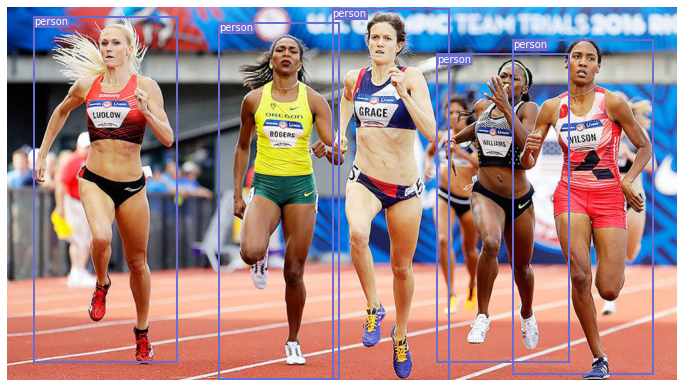

In [15]:
# cargar imagen y obtener detecciones
#esto es con un threshold de confianza de 0.1
conf_thres=0.1
#si aplicamos un threshold diferente:
#conf_thres=0.8 #umbral más estricto
img_path = "images/olympic-trials.jpg"
prev_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# generar colores para los bounding-box
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

#paddings
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # recorrer detecciones y dibujar bounding boxes
    # hacemos un loop a través de todas las detecciones
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
# guardar imagen
plt.savefig(img_path.replace(".jpg", "-det.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

## 3. Detectando objetos en video

---
YOLO es muy usado en detección de objetos en video.


In [16]:
import cv2
import imutils

In [17]:
vs = cv2.VideoCapture('test2_cam1_100.MP4')

In [19]:
vs

<VideoCapture 0x7fbf4e16edf0>

In [22]:
#treshold de confianza | normalmente debe ser 0.1
conf_thres = 0.1
#maximo threshold para bouding box
nms_thres = 0.1

#grabar o no grabar el video
writer = None

#para empezar a recorrer frames del video
i = 1
frames_maximos = 10000

while i < frames_maximos:
  (grab, frame) = vs.read()

  i = i+1
  #si no hay record/grabacion de imagen, cierra loop
  if not grab:
    break

  prev_time = time.time()

  #cambios
  newImg = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

  img = Image.fromarray(newImg)
  ####################################################
  #Lo demás es similar a lo de arriba
  ####################################################

  detections = detect_image(img)
  inference_time = datetime.timedelta(seconds=time.time() - prev_time)
  print ('Inference Time: %s' % (inference_time))

  # generar colores para los bounding-box
  cmap = plt.get_cmap('tab20b')
  colors = [cmap(i) for i in np.linspace(0, 1, 20)]

  img = np.array(img)
  plt.figure()
  fig, ax = plt.subplots(1, figsize=(12,9))
  ax.imshow(img)

  #paddings
  pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
  pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
  unpad_h = img_size - pad_y
  unpad_w = img_size - pad_x

  if detections is not None:
      unique_labels = detections[:, -1].cpu().unique()
      n_cls_preds = len(unique_labels)
      bbox_colors = random.sample(colors, n_cls_preds)
      # recorrer detecciones y dibujar bounding boxes
      # hacemos un loop a través de todas las detecciones
      for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
          box_h = ((y2 - y1) / unpad_h) * img.shape[0]
          box_w = ((x2 - x1) / unpad_w) * img.shape[1]
          y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
          x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
          color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]

          #redefinimos la nueva imagen para que pueda verse adecuadamente
          #los dos ultimos solos: color de la linea y grosor (2)
          newImg = cv2.rectangle(newImg, (x1, y1), (x1 + box_w, y1 + box_h), color, 2)
          newImg = cv2.putText(newImg, classes[int(cls_pred)], (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2)
      
      if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"XVID")
        writer = cv2.VideoWriter("videoOutput.avi", fourcc, 30, (newImg.shape[1], newImg.shape[0]), True)
      writer.write(cv2.cvtColor(newImg, cv2.COLOR_RGB2BGR))

Output hidden; open in https://colab.research.google.com to view.